In [1]:
import os, shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
train_path = os.path.join(os.getcwd(),'AffectNet', 'train')

def showIMG(X, y):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(y[i])
        plt.axis('off')
    plt.show()

def create_downsampled_folder(label, label_suppr = []):
    downsampled_path = os.path.join(os.getcwd(), 'AffectNet_downsampled')
    data_path = os.path.join(os.getcwd(), 'AffectNet')
    if os.path.exists(downsampled_path):
        print('Folder already exists')
        return
    os.makedirs(downsampled_path)
    os.makedirs(os.path.join(downsampled_path, 'train'))
    os.makedirs(os.path.join(downsampled_path, 'test'))
    os.makedirs(os.path.join(downsampled_path, 'val'))

    nb_img = len(os.listdir(os.path.join(data_path, 'train', label)))

    for emotion in os.listdir(os.path.join(data_path, 'train')):
        if emotion in label_suppr:
            continue
        os.makedirs(os.path.join(downsampled_path, 'train', emotion))
        # Copie nb_img images de l'émotion dans le dossier downsampled
        for img in os.listdir(os.path.join(data_path, 'train', emotion))[:nb_img]:
            shutil.copy(os.path.join(data_path, 'train', emotion, img), os.path.join(downsampled_path, 'train', emotion, img))
    
    for emotion in os.listdir(os.path.join(data_path, 'test')):
        if emotion in label_suppr:
            continue
        os.makedirs(os.path.join(downsampled_path, 'test', emotion))
        # Copie nb_img images de l'émotion dans le dossier downsampled
        for img in os.listdir(os.path.join(data_path, 'test', emotion)):
            shutil.copy(os.path.join(data_path, 'test', emotion, img), os.path.join(downsampled_path,'test', emotion, img))

    for emotion in os.listdir(os.path.join(data_path, 'val')):
        if emotion in label_suppr:
            continue
        os.makedirs(os.path.join(downsampled_path, 'val', emotion))
        # Copie nb_img images de l'émotion dans le dossier downsampled
        for img in os.listdir(os.path.join(data_path, 'val', emotion)):
            shutil.copy(os.path.join(data_path, 'val', emotion, img), os.path.join(downsampled_path,'val', emotion, img))


    print('Folder created')

# Compte le nombre d'images par émotion
def count_images(data_path):
    count = {}
    for emotion in os.listdir(data_path):
        count[emotion] = len(os.listdir(os.path.join(data_path, emotion)))
    print(data_path)
    print(count)
    print('Total images:', sum(count.values()))

create_downsampled_folder('7')    

count_images(os.path.join(os.getcwd(), 'AffectNet', 'train'))
count_images(os.path.join(os.getcwd(), 'AffectNet_downsampled', 'train'))

Folder already exists
c:\Users\bluek\Desktop\cour\HexagoneM2\Emotion\AffectNet\train
{'0': 5000, '1': 3803, '2': 5000, '3': 5000, '4': 5000, '5': 5000, '6': 5000, '7': 3750}
Total images: 37553
c:\Users\bluek\Desktop\cour\HexagoneM2\Emotion\AffectNet_downsampled\train
{'0': 3750, '1': 3750, '2': 3750, '3': 3750, '4': 3750, '5': 3750, '6': 3750, '7': 3750}
Total images: 30000


In [3]:
# Définir les chemins
test_path = os.path.join(os.getcwd(), 'AffectNet_downsampled', 'test')
train_path = os.path.join(os.getcwd(), 'AffectNet_downsampled', 'train')
val_path = os.path.join(os.getcwd(), 'AffectNet_downsampled', 'val')

# Définir les transformations pour l'augmentation des données
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),  # Rotation aléatoire
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom aléatoire
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation
])

# Charger les ensembles de données
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]))
val_dataset = datasets.ImageFolder(root=val_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]))

# Créer des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [5]:
import torch.nn as nn
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomModel, self).__init__()
        # Charger le modèle ResNet18 pré-entraîné
        self.base_model = models.resnet18(pretrained=True)
        # Geler les poids de la base
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.base_model(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Créer une instance du modèle
model = CustomModel(num_classes=8)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Afficher le résumé du modèle
print(model)


c:\Users\bluek\.conda\envs\main\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bluek\.conda\envs\main\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [34]:
# Entrainement du modele
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Pour afficher la progression de l'entraînement

# Définir le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacer le modèle vers le dispositif
model = CustomModel(num_classes=8).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Paramètres pour l'arrêt précoce
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Nombre d'époques
num_epochs = 30

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()  # Mettre le modèle en mode entraînement
    train_loss = 0.0
    correct = 0
    total = 0

    # Itération sur le DataLoader d'entraînement
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Déplacer les données vers le dispositif

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Passer les données à travers le modèle
        outputs = model(images)

        # Calculer la perte
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Calculer les prédictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Rétropropagation et optimisation
        loss.backward()
        optimizer.step()

    # Calculer la perte et la précision d'entraînement
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()  # Mettre le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculer la perte et la précision de validation
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    # Afficher les résultats
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Vérifier l'arrêt précoce
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger le meilleur modèle après l'entraînement
model.load_state_dict(torch.load('best_model.pth'))


  3%|▎         | 15/469 [00:08<04:15,  1.77it/s]


KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Définir le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Déplacer le modèle vers le dispositif
model = CustomModel(num_classes=8).to(device)

# Chargement du meilleur modèle
model.load_state_dict(torch.load('resnet18_32.pth'))

# Évaluation du modèle
model.eval()  # Mettre le modèle en mode évaluation
test_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():  # Pas de calcul de gradients pendant l'évaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Passer les données à travers le modèle
        outputs = model(images)

        # Calculer la perte
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculer les prédictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Stocker les vraies étiquettes et les prédictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculer la perte et la précision de test
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Afficher le rapport de classification
print(classification_report(y_true, y_pred))



C:\Users\bluek\AppData\Local\Temp\ipykernel_20176\3101784644.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_32.pth'))


Test Loss: 1.7721, Test Accuracy: 32.25%
              precision    recall  f1-score   support

           0       0.35      0.28      0.31       400
           1       0.34      0.27      0.30       400
           2       0.40      0.33      0.36       400
           3       0.38      0.52      0.44       400
           4       0.31      0.17      0.22       400
           5       0.28      0.47      0.35       400
           6       0.29      0.23      0.25       400
           7       0.27      0.32      0.29       400

    accuracy                           0.32      3200
   macro avg       0.33      0.32      0.32      3200
weighted avg       0.33      0.32      0.32      3200



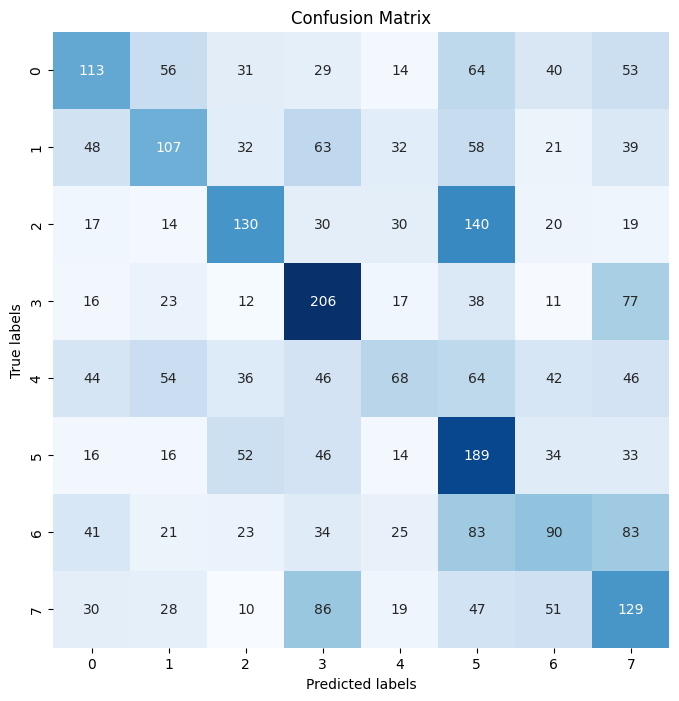

In [10]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

